In [37]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
from PIL import Image
from torchvision import models, transforms
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, accuracy_score
import time


In [39]:
# Load and preview the dataset
train = pd.read_csv('/kaggle/input/jutepest/train.csv')
train.head()

,filename,class
0,data_813.jpg,Jute Stem Weevil
1,data_6274.jpg,Mealybug
2,data_2317.jpg,Black Hairy
3,data_2124.jpg,Termite
4,data_5974.jpg,Jute Aphid


In [40]:
# Encode class labels to integers
label_encoder = LabelEncoder()
train['class'] = label_encoder.fit_transform(train['class'])

In [41]:
# Define the image transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])


In [42]:
# Custom dataset class
class JutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 0])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        label = self.dataframe.iloc[idx, 1]
        label = torch.tensor(label, dtype=torch.long)
        
        return image, label

In [43]:
# Create dataset and split into training and validation sets
train_dir = '/kaggle/input/jutepest/train_images/'
dataset = JutePestDataset(train, train_dir, transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

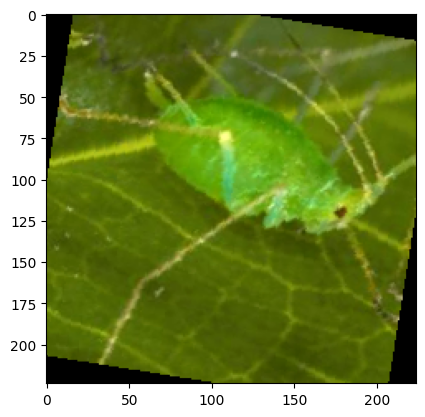

In [44]:
# Display a sample image
plt.imshow(torch.permute(dataset[4][0], (1, 2, 0)))
plt.show()

In [45]:
# Create DataLoader instances
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

### VGG-Like Model


In [46]:
# Define the custom VGG-like model
class Block(nn.Module):
    def __init__(self, in_channels, filters, kernel_size, repetitions, pool_size=2, strides=2):
        super(Block, self).__init__()
        self.filters = filters
        self.kernel_size = kernel_size
        self.repetitions = repetitions

        self.conv_layers = nn.ModuleList([
            nn.Conv2d(in_channels=in_channels if i == 0 else self.filters,
                      out_channels=self.filters,
                      kernel_size=self.kernel_size,
                      padding=1) for i in range(self.repetitions)
        ])
        self.bn_layers = nn.ModuleList([
            nn.BatchNorm2d(self.filters) for _ in range(self.repetitions)
        ])

        self.max_pool = nn.MaxPool2d(kernel_size=pool_size, stride=strides)

    def forward(self, x):
        for conv_layer, bn_layer in zip(self.conv_layers, self.bn_layers):
            x = F.relu(bn_layer(conv_layer(x)))

        x = self.max_pool(x)
        return x

In [47]:
class MyVGG(nn.Module):
    def __init__(self, num_classes):
        super(MyVGG, self).__init__()
        self.block_a = Block(3, 64, 3, 2)
        self.block_b = Block(64, 128, 3, 2)
        self.block_c = Block(128, 256, 3, 3)
        self.block_d = Block(256, 512, 3, 3)
        self.block_e = Block(512, 512, 3, 3)
        self.flatten_a = nn.Flatten()
        self.fc_a = nn.Linear(512 * 7 * 7, 4096)
        self.dropout_a = nn.Dropout(0.5)
        self.fc_b = nn.Linear(4096, 1024)
        self.dropout_b = nn.Dropout(0.5)
        self.fc_c = nn.Linear(1024, 512)
        self.dropout_c = nn.Dropout(0.5)
        self.classifier = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.block_a(x)
        x = self.block_b(x)
        x = self.block_c(x)
        x = self.block_d(x)
        x = self.block_e(x)
        x = self.flatten_a(x)
        x = F.relu(self.fc_a(x))
        x = self.dropout_a(x)
        x = F.relu(self.fc_b(x))
        x = self.dropout_b(x)
        x = F.relu(self.fc_c(x))
        x = self.dropout_c(x)
        x = self.classifier(x)
        return x

In [48]:
# Initialize the model, loss function, and optimizer
model = MyVGG(num_classes=17)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.75)

In [49]:
# Print model summary
from torchinfo import summary
summary(model, (32, 3, 224, 224))

Layer (type:depth-idx)                   Output Shape              Param #
MyVGG                                    [32, 17]                  --
├─Block: 1-1                             [32, 64, 112, 112]        --
│    └─ModuleList: 2-3                   --                        (recursive)
│    │    └─Conv2d: 3-1                  [32, 64, 224, 224]        1,792
│    └─ModuleList: 2-4                   --                        (recursive)
│    │    └─BatchNorm2d: 3-2             [32, 64, 224, 224]        128
│    └─ModuleList: 2-3                   --                        (recursive)
│    │    └─Conv2d: 3-3                  [32, 64, 224, 224]        36,928
│    └─ModuleList: 2-4                   --                        (recursive)
│    │    └─BatchNorm2d: 3-4             [32, 64, 224, 224]        128
│    └─MaxPool2d: 2-5                    [32, 64, 112, 112]        --
├─Block: 1-2                             [32, 128, 56, 56]         --
│    └─ModuleList: 2-8                  

In [50]:
# Determine the device to use
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
torch.cuda.empty_cache()
model.to(device)

MyVGG(
  (block_a): Block(
    (conv_layers): ModuleList(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bn_layers): ModuleList(
      (0-1): 2 x BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_b): Block(
    (conv_layers): ModuleList(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
    (bn_layers): ModuleList(
      (0-1): 2 x BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_c): Block(
    (conv_layers): ModuleList(
      (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), 

In [51]:
# Fungsi untuk menghitung akurasi
def calc_accuracy(true, pred):
    pred = F.softmax(pred, dim=1)
    acc = (true == pred.argmax(dim=1)).float().mean().item()
    return round(acc * 100, 2)

In [52]:
# Fungsi untuk menghitung F1 Score
def calc_f1_score(true, pred):
    pred = F.softmax(pred, dim=1).argmax(dim=1)
    true = true.cpu().numpy()
    pred = pred.cpu().numpy()
    return f1_score(true, pred, average='weighted')

## Melanjutkan Epoch Sebelumnya


In [53]:
checkpoint_path = ''

# Check if checkpoint exists
if os.path.exists(checkpoint_path) and checkpoint_path:
    # Load the checkpoint
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    best_val_loss = checkpoint['best_val_loss']
    patience_counter = checkpoint['patience_counter']
    train_loss = checkpoint['train_loss']
    train_accuracy = checkpoint['train_accuracy']
    train_f1_score = checkpoint['train_f1_score']
    val_loss = checkpoint['val_loss']
    val_accuracy = checkpoint['val_accuracy']
    val_f1_score = checkpoint['val_f1_score']
    print(f"Checkpoint loaded, starting from epoch {start_epoch}")
else:
    # Initialize training and validation statistics
    start_epoch = 0
    best_val_loss = np.inf
    patience_counter = 0
    train_loss = []
    train_accuracy = []
    train_f1_score = []
    val_loss = []
    val_accuracy = []
    val_f1_score = []
    print("No checkpoint found, starting from scratch")

No checkpoint found, starting from scratch


## Training

In [54]:
# Initialize training and validation statistics
epochs = 100
patience = 6

In [55]:
# Training loop
for epoch in range(start_epoch, epochs):
    start_time = time.time()
    train_epoch_loss = []
    train_epoch_accuracy = []
    train_epoch_f1_score = []
    val_epoch_loss = []
    val_epoch_accuracy = []
    val_epoch_f1_score = []

    model.train()
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{epochs}", unit='batch') as pbar:
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)
            loss.backward()
            optimizer.step()

            train_epoch_loss.append(loss.item())
            train_epoch_accuracy.append(acc)
            train_epoch_f1_score.append(f1)

            pbar.set_postfix({'Training Loss': np.mean(train_epoch_loss), 'Training Accuracy': np.mean(train_epoch_accuracy), 'Training F1 Score': np.mean(train_epoch_f1_score)})
            pbar.update(1)

    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            preds = model(images)
            acc = calc_accuracy(labels, preds)
            f1 = calc_f1_score(labels, preds)
            loss = criterion(preds, labels)

            val_epoch_loss.append(loss.item())
            val_epoch_accuracy.append(acc)
            val_epoch_f1_score.append(f1)

    train_epoch_loss = np.mean(train_epoch_loss)
    train_epoch_accuracy = np.mean(train_epoch_accuracy)
    train_epoch_f1_score = np.mean(train_epoch_f1_score)
    val_epoch_loss = np.mean(val_epoch_loss)
    val_epoch_accuracy = np.mean(val_epoch_accuracy)
    val_epoch_f1_score = np.mean(val_epoch_f1_score)

    train_loss.append(train_epoch_loss)
    train_accuracy.append(train_epoch_accuracy)
    train_f1_score.append(train_epoch_f1_score)
    val_loss.append(val_epoch_loss)
    val_accuracy.append(val_epoch_accuracy)
    val_f1_score.append(val_epoch_f1_score)

    end_time = time.time()
    epoch_duration = end_time - start_time

    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {train_epoch_loss:.4f}, Training Accuracy: {train_epoch_accuracy:.2f}%, Training F1 Score: {train_epoch_f1_score:.2f}")
    print(f"Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {val_epoch_accuracy:.2f}%, Validation F1 Score: {val_epoch_f1_score:.2f}, Epoch Duration: {epoch_duration:.2f} seconds")

    # Save the model and optimizer state every 10 epochs
    if (epoch + 1) % 10 == 0 or (epoch + 1) == epochs:
        checkpoint = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score
       }
        torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
        print(f'Model saved at epoch {epoch + 1}')

    if val_epoch_loss < best_val_loss:
        best_val_loss = val_epoch_loss
        patience_counter = 0
        checkpoint_best = {
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_val_loss': best_val_loss,
            'patience_counter': patience_counter,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'train_f1_score': train_f1_score,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'val_f1_score': val_f1_score
        }
        torch.save(checkpoint_best, 'checkpoint_best.pth')
        torch.save(model.state_dict(), 'best_model.pth')
        print('Best model saved')
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered")
            checkpoint = {
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'patience_counter': patience_counter,
                'train_loss': train_loss,
                'train_accuracy': train_accuracy,
                'train_f1_score': train_f1_score,
                'val_loss': val_loss,
                'val_accuracy': val_accuracy,
                'val_f1_score': val_f1_score
           }
            torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
            print(f'Model saved at epoch {epoch + 1} due to early stopping')
            break

    lr_scheduler.step()

Epoch 1/100: 100%|██████████| 154/154 [01:51<00:00,  1.38batch/s, Training Loss=2.82, Training Accuracy=8.85, Training F1 Score=0.0678]


Epoch 1/100, Training Loss: 2.8217, Training Accuracy: 8.85%, Training F1 Score: 0.07
Validation Loss: 2.7186, Validation Accuracy: 13.40%, Validation F1 Score: 0.07, Epoch Duration: 131.36 seconds
Best model saved


Epoch 2/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=2.6, Training Accuracy=15, Training F1 Score=0.126]   


Epoch 2/100, Training Loss: 2.6037, Training Accuracy: 15.00%, Training F1 Score: 0.13
Validation Loss: 2.5364, Validation Accuracy: 20.38%, Validation F1 Score: 0.14, Epoch Duration: 107.25 seconds
Best model saved


Epoch 3/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=2.44, Training Accuracy=19.3, Training F1 Score=0.17] 


Epoch 3/100, Training Loss: 2.4426, Training Accuracy: 19.33%, Training F1 Score: 0.17
Validation Loss: 2.2709, Validation Accuracy: 27.93%, Validation F1 Score: 0.22, Epoch Duration: 112.30 seconds
Best model saved


Epoch 4/100: 100%|██████████| 154/154 [01:35<00:00,  1.61batch/s, Training Loss=2.31, Training Accuracy=24.8, Training F1 Score=0.216]


Epoch 4/100, Training Loss: 2.3125, Training Accuracy: 24.78%, Training F1 Score: 0.22
Validation Loss: 2.1921, Validation Accuracy: 28.19%, Validation F1 Score: 0.23, Epoch Duration: 111.81 seconds
Best model saved


Epoch 5/100: 100%|██████████| 154/154 [01:33<00:00,  1.64batch/s, Training Loss=2.22, Training Accuracy=28.4, Training F1 Score=0.258]


Epoch 5/100, Training Loss: 2.2189, Training Accuracy: 28.42%, Training F1 Score: 0.26
Validation Loss: 2.0653, Validation Accuracy: 29.85%, Validation F1 Score: 0.24, Epoch Duration: 109.33 seconds
Best model saved


Epoch 6/100: 100%|██████████| 154/154 [01:30<00:00,  1.69batch/s, Training Loss=2.12, Training Accuracy=30.6, Training F1 Score=0.279]


Epoch 6/100, Training Loss: 2.1196, Training Accuracy: 30.55%, Training F1 Score: 0.28
Validation Loss: 2.1398, Validation Accuracy: 30.82%, Validation F1 Score: 0.27, Epoch Duration: 105.92 seconds


Epoch 7/100: 100%|██████████| 154/154 [01:31<00:00,  1.69batch/s, Training Loss=2.05, Training Accuracy=32.6, Training F1 Score=0.301]


Epoch 7/100, Training Loss: 2.0506, Training Accuracy: 32.61%, Training F1 Score: 0.30
Validation Loss: 1.9411, Validation Accuracy: 36.79%, Validation F1 Score: 0.34, Epoch Duration: 105.81 seconds
Best model saved


Epoch 8/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=1.96, Training Accuracy=36.3, Training F1 Score=0.344]


Epoch 8/100, Training Loss: 1.9595, Training Accuracy: 36.32%, Training F1 Score: 0.34
Validation Loss: 2.0240, Validation Accuracy: 34.36%, Validation F1 Score: 0.32, Epoch Duration: 105.23 seconds


Epoch 9/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.92, Training Accuracy=37.7, Training F1 Score=0.357]


Epoch 9/100, Training Loss: 1.9195, Training Accuracy: 37.66%, Training F1 Score: 0.36
Validation Loss: 1.9009, Validation Accuracy: 39.70%, Validation F1 Score: 0.37, Epoch Duration: 107.05 seconds
Best model saved


Epoch 10/100: 100%|██████████| 154/154 [01:30<00:00,  1.69batch/s, Training Loss=1.87, Training Accuracy=40, Training F1 Score=0.384]  


Epoch 10/100, Training Loss: 1.8678, Training Accuracy: 40.02%, Training F1 Score: 0.38
Validation Loss: 1.7325, Validation Accuracy: 43.42%, Validation F1 Score: 0.40, Epoch Duration: 105.63 seconds
Model saved at epoch 10
Best model saved


Epoch 11/100: 100%|██████████| 154/154 [01:29<00:00,  1.71batch/s, Training Loss=1.74, Training Accuracy=43.4, Training F1 Score=0.416]


Epoch 11/100, Training Loss: 1.7381, Training Accuracy: 43.43%, Training F1 Score: 0.42
Validation Loss: 1.6119, Validation Accuracy: 48.21%, Validation F1 Score: 0.45, Epoch Duration: 104.27 seconds
Best model saved


Epoch 12/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=1.72, Training Accuracy=44.5, Training F1 Score=0.434]


Epoch 12/100, Training Loss: 1.7168, Training Accuracy: 44.53%, Training F1 Score: 0.43
Validation Loss: 1.5541, Validation Accuracy: 49.02%, Validation F1 Score: 0.46, Epoch Duration: 104.39 seconds
Best model saved


Epoch 13/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=1.61, Training Accuracy=48.4, Training F1 Score=0.463]


Epoch 13/100, Training Loss: 1.6066, Training Accuracy: 48.38%, Training F1 Score: 0.46
Validation Loss: 1.4662, Validation Accuracy: 54.09%, Validation F1 Score: 0.52, Epoch Duration: 105.51 seconds
Best model saved


Epoch 14/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=1.57, Training Accuracy=49.7, Training F1 Score=0.481]


Epoch 14/100, Training Loss: 1.5657, Training Accuracy: 49.66%, Training F1 Score: 0.48
Validation Loss: 1.4416, Validation Accuracy: 53.46%, Validation F1 Score: 0.52, Epoch Duration: 105.49 seconds
Best model saved


Epoch 15/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=1.5, Training Accuracy=52, Training F1 Score=0.512]   


Epoch 15/100, Training Loss: 1.5037, Training Accuracy: 52.00%, Training F1 Score: 0.51
Validation Loss: 1.5023, Validation Accuracy: 52.64%, Validation F1 Score: 0.51, Epoch Duration: 105.65 seconds


Epoch 16/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.43, Training Accuracy=54.2, Training F1 Score=0.536]


Epoch 16/100, Training Loss: 1.4253, Training Accuracy: 54.22%, Training F1 Score: 0.54
Validation Loss: 1.2981, Validation Accuracy: 58.25%, Validation F1 Score: 0.57, Epoch Duration: 107.10 seconds
Best model saved


Epoch 17/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=1.37, Training Accuracy=56.5, Training F1 Score=0.557]


Epoch 17/100, Training Loss: 1.3701, Training Accuracy: 56.49%, Training F1 Score: 0.56
Validation Loss: 1.3089, Validation Accuracy: 60.20%, Validation F1 Score: 0.58, Epoch Duration: 105.23 seconds


Epoch 18/100: 100%|██████████| 154/154 [01:30<00:00,  1.71batch/s, Training Loss=1.29, Training Accuracy=59.1, Training F1 Score=0.586]


Epoch 18/100, Training Loss: 1.2929, Training Accuracy: 59.09%, Training F1 Score: 0.59
Validation Loss: 1.2012, Validation Accuracy: 61.36%, Validation F1 Score: 0.60, Epoch Duration: 104.97 seconds
Best model saved


Epoch 19/100: 100%|██████████| 154/154 [01:31<00:00,  1.68batch/s, Training Loss=1.25, Training Accuracy=60.9, Training F1 Score=0.604]


Epoch 19/100, Training Loss: 1.2526, Training Accuracy: 60.92%, Training F1 Score: 0.60
Validation Loss: 1.1102, Validation Accuracy: 65.75%, Validation F1 Score: 0.65, Epoch Duration: 106.37 seconds
Best model saved


Epoch 20/100: 100%|██████████| 154/154 [01:30<00:00,  1.71batch/s, Training Loss=1.18, Training Accuracy=62.9, Training F1 Score=0.622]


Epoch 20/100, Training Loss: 1.1753, Training Accuracy: 62.92%, Training F1 Score: 0.62
Validation Loss: 1.1397, Validation Accuracy: 64.18%, Validation F1 Score: 0.63, Epoch Duration: 104.77 seconds
Model saved at epoch 20


Epoch 21/100: 100%|██████████| 154/154 [01:30<00:00,  1.71batch/s, Training Loss=1.1, Training Accuracy=64.7, Training F1 Score=0.644] 


Epoch 21/100, Training Loss: 1.0971, Training Accuracy: 64.74%, Training F1 Score: 0.64
Validation Loss: 1.0360, Validation Accuracy: 69.07%, Validation F1 Score: 0.68, Epoch Duration: 104.41 seconds
Best model saved


Epoch 22/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=1.04, Training Accuracy=67, Training F1 Score=0.666]  


Epoch 22/100, Training Loss: 1.0375, Training Accuracy: 66.97%, Training F1 Score: 0.67
Validation Loss: 1.0219, Validation Accuracy: 68.37%, Validation F1 Score: 0.67, Epoch Duration: 105.31 seconds
Best model saved


Epoch 23/100: 100%|██████████| 154/154 [01:30<00:00,  1.71batch/s, Training Loss=1, Training Accuracy=68.2, Training F1 Score=0.679]    


Epoch 23/100, Training Loss: 1.0033, Training Accuracy: 68.16%, Training F1 Score: 0.68
Validation Loss: 0.9210, Validation Accuracy: 71.22%, Validation F1 Score: 0.69, Epoch Duration: 105.20 seconds
Best model saved


Epoch 24/100: 100%|██████████| 154/154 [01:30<00:00,  1.70batch/s, Training Loss=0.97, Training Accuracy=69.3, Training F1 Score=0.687] 


Epoch 24/100, Training Loss: 0.9702, Training Accuracy: 69.25%, Training F1 Score: 0.69
Validation Loss: 0.8932, Validation Accuracy: 72.88%, Validation F1 Score: 0.72, Epoch Duration: 105.39 seconds
Best model saved


Epoch 25/100: 100%|██████████| 154/154 [01:29<00:00,  1.71batch/s, Training Loss=0.913, Training Accuracy=71.1, Training F1 Score=0.706]


Epoch 25/100, Training Loss: 0.9127, Training Accuracy: 71.10%, Training F1 Score: 0.71
Validation Loss: 0.8214, Validation Accuracy: 75.63%, Validation F1 Score: 0.75, Epoch Duration: 104.63 seconds
Best model saved


Epoch 26/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.843, Training Accuracy=72.8, Training F1 Score=0.728]


Epoch 26/100, Training Loss: 0.8428, Training Accuracy: 72.80%, Training F1 Score: 0.73
Validation Loss: 0.8352, Validation Accuracy: 74.19%, Validation F1 Score: 0.73, Epoch Duration: 104.23 seconds


Epoch 27/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.821, Training Accuracy=74.1, Training F1 Score=0.742]


Epoch 27/100, Training Loss: 0.8213, Training Accuracy: 74.09%, Training F1 Score: 0.74
Validation Loss: 0.7991, Validation Accuracy: 75.69%, Validation F1 Score: 0.75, Epoch Duration: 104.31 seconds
Best model saved


Epoch 28/100: 100%|██████████| 154/154 [01:29<00:00,  1.73batch/s, Training Loss=0.805, Training Accuracy=74.1, Training F1 Score=0.741]


Epoch 28/100, Training Loss: 0.8049, Training Accuracy: 74.06%, Training F1 Score: 0.74
Validation Loss: 0.7895, Validation Accuracy: 76.89%, Validation F1 Score: 0.76, Epoch Duration: 103.64 seconds
Best model saved


Epoch 29/100: 100%|██████████| 154/154 [01:29<00:00,  1.73batch/s, Training Loss=0.739, Training Accuracy=76.1, Training F1 Score=0.761]


Epoch 29/100, Training Loss: 0.7394, Training Accuracy: 76.12%, Training F1 Score: 0.76
Validation Loss: 0.7908, Validation Accuracy: 76.59%, Validation F1 Score: 0.75, Epoch Duration: 103.43 seconds


Epoch 30/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.749, Training Accuracy=76, Training F1 Score=0.759]  


Epoch 30/100, Training Loss: 0.7488, Training Accuracy: 76.04%, Training F1 Score: 0.76
Validation Loss: 0.7001, Validation Accuracy: 78.91%, Validation F1 Score: 0.78, Epoch Duration: 104.12 seconds
Model saved at epoch 30
Best model saved


Epoch 31/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.658, Training Accuracy=79.7, Training F1 Score=0.795]


Epoch 31/100, Training Loss: 0.6578, Training Accuracy: 79.65%, Training F1 Score: 0.79
Validation Loss: 0.7023, Validation Accuracy: 78.51%, Validation F1 Score: 0.78, Epoch Duration: 103.13 seconds


Epoch 32/100: 100%|██████████| 154/154 [01:29<00:00,  1.73batch/s, Training Loss=0.652, Training Accuracy=79.3, Training F1 Score=0.792]


Epoch 32/100, Training Loss: 0.6518, Training Accuracy: 79.30%, Training F1 Score: 0.79
Validation Loss: 0.6407, Validation Accuracy: 80.04%, Validation F1 Score: 0.79, Epoch Duration: 103.58 seconds
Best model saved


Epoch 33/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.622, Training Accuracy=80, Training F1 Score=0.799]  


Epoch 33/100, Training Loss: 0.6218, Training Accuracy: 79.96%, Training F1 Score: 0.80
Validation Loss: 0.6827, Validation Accuracy: 78.57%, Validation F1 Score: 0.78, Epoch Duration: 104.14 seconds


Epoch 34/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.608, Training Accuracy=81.3, Training F1 Score=0.813]


Epoch 34/100, Training Loss: 0.6075, Training Accuracy: 81.31%, Training F1 Score: 0.81
Validation Loss: 0.6317, Validation Accuracy: 79.82%, Validation F1 Score: 0.79, Epoch Duration: 103.75 seconds
Best model saved


Epoch 35/100: 100%|██████████| 154/154 [01:29<00:00,  1.73batch/s, Training Loss=0.588, Training Accuracy=81.1, Training F1 Score=0.808]


Epoch 35/100, Training Loss: 0.5876, Training Accuracy: 81.14%, Training F1 Score: 0.81
Validation Loss: 0.7151, Validation Accuracy: 77.07%, Validation F1 Score: 0.76, Epoch Duration: 103.66 seconds


Epoch 36/100: 100%|██████████| 154/154 [01:28<00:00,  1.73batch/s, Training Loss=0.546, Training Accuracy=82.8, Training F1 Score=0.83] 


Epoch 36/100, Training Loss: 0.5463, Training Accuracy: 82.77%, Training F1 Score: 0.83
Validation Loss: 0.5808, Validation Accuracy: 82.57%, Validation F1 Score: 0.82, Epoch Duration: 103.69 seconds
Best model saved


Epoch 37/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.519, Training Accuracy=83.4, Training F1 Score=0.835]


Epoch 37/100, Training Loss: 0.5193, Training Accuracy: 83.37%, Training F1 Score: 0.84
Validation Loss: 0.5414, Validation Accuracy: 84.12%, Validation F1 Score: 0.83, Epoch Duration: 103.12 seconds
Best model saved


Epoch 38/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.525, Training Accuracy=83.5, Training F1 Score=0.833]


Epoch 38/100, Training Loss: 0.5250, Training Accuracy: 83.50%, Training F1 Score: 0.83
Validation Loss: 0.5473, Validation Accuracy: 82.92%, Validation F1 Score: 0.82, Epoch Duration: 103.79 seconds


Epoch 39/100: 100%|██████████| 154/154 [01:29<00:00,  1.73batch/s, Training Loss=0.511, Training Accuracy=83.5, Training F1 Score=0.836]


Epoch 39/100, Training Loss: 0.5106, Training Accuracy: 83.55%, Training F1 Score: 0.84
Validation Loss: 0.6014, Validation Accuracy: 82.44%, Validation F1 Score: 0.82, Epoch Duration: 103.90 seconds


Epoch 40/100: 100%|██████████| 154/154 [01:28<00:00,  1.73batch/s, Training Loss=0.48, Training Accuracy=84.7, Training F1 Score=0.849] 


Epoch 40/100, Training Loss: 0.4797, Training Accuracy: 84.74%, Training F1 Score: 0.85
Validation Loss: 0.5342, Validation Accuracy: 83.88%, Validation F1 Score: 0.83, Epoch Duration: 103.12 seconds
Model saved at epoch 40
Best model saved


Epoch 41/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.44, Training Accuracy=86.2, Training F1 Score=0.859] 


Epoch 41/100, Training Loss: 0.4402, Training Accuracy: 86.17%, Training F1 Score: 0.86
Validation Loss: 0.5240, Validation Accuracy: 83.45%, Validation F1 Score: 0.83, Epoch Duration: 104.14 seconds
Best model saved


Epoch 42/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.429, Training Accuracy=86.4, Training F1 Score=0.866]


Epoch 42/100, Training Loss: 0.4288, Training Accuracy: 86.42%, Training F1 Score: 0.87
Validation Loss: 0.5410, Validation Accuracy: 83.85%, Validation F1 Score: 0.83, Epoch Duration: 103.88 seconds


Epoch 43/100: 100%|██████████| 154/154 [01:28<00:00,  1.73batch/s, Training Loss=0.427, Training Accuracy=86.4, Training F1 Score=0.866]


Epoch 43/100, Training Loss: 0.4272, Training Accuracy: 86.42%, Training F1 Score: 0.87
Validation Loss: 0.4857, Validation Accuracy: 85.35%, Validation F1 Score: 0.85, Epoch Duration: 103.36 seconds
Best model saved


Epoch 44/100: 100%|██████████| 154/154 [01:28<00:00,  1.73batch/s, Training Loss=0.426, Training Accuracy=86.2, Training F1 Score=0.864]


Epoch 44/100, Training Loss: 0.4260, Training Accuracy: 86.22%, Training F1 Score: 0.86
Validation Loss: 0.4881, Validation Accuracy: 85.81%, Validation F1 Score: 0.85, Epoch Duration: 103.09 seconds


Epoch 45/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.418, Training Accuracy=87, Training F1 Score=0.872]  


Epoch 45/100, Training Loss: 0.4181, Training Accuracy: 86.97%, Training F1 Score: 0.87
Validation Loss: 0.4719, Validation Accuracy: 85.69%, Validation F1 Score: 0.85, Epoch Duration: 103.98 seconds
Best model saved


Epoch 46/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.384, Training Accuracy=87.7, Training F1 Score=0.879]


Epoch 46/100, Training Loss: 0.3838, Training Accuracy: 87.74%, Training F1 Score: 0.88
Validation Loss: 0.4909, Validation Accuracy: 85.21%, Validation F1 Score: 0.85, Epoch Duration: 104.47 seconds


Epoch 47/100: 100%|██████████| 154/154 [01:28<00:00,  1.73batch/s, Training Loss=0.388, Training Accuracy=87.7, Training F1 Score=0.877]


Epoch 47/100, Training Loss: 0.3879, Training Accuracy: 87.66%, Training F1 Score: 0.88
Validation Loss: 0.4855, Validation Accuracy: 86.71%, Validation F1 Score: 0.86, Epoch Duration: 103.35 seconds


Epoch 48/100: 100%|██████████| 154/154 [01:28<00:00,  1.74batch/s, Training Loss=0.389, Training Accuracy=87.7, Training F1 Score=0.88] 


Epoch 48/100, Training Loss: 0.3886, Training Accuracy: 87.70%, Training F1 Score: 0.88
Validation Loss: 0.5264, Validation Accuracy: 84.12%, Validation F1 Score: 0.83, Epoch Duration: 103.08 seconds


Epoch 49/100: 100%|██████████| 154/154 [01:28<00:00,  1.73batch/s, Training Loss=0.382, Training Accuracy=87.8, Training F1 Score=0.88] 


Epoch 49/100, Training Loss: 0.3816, Training Accuracy: 87.78%, Training F1 Score: 0.88
Validation Loss: 0.4902, Validation Accuracy: 86.55%, Validation F1 Score: 0.86, Epoch Duration: 103.25 seconds


Epoch 50/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.341, Training Accuracy=89.4, Training F1 Score=0.895]


Epoch 50/100, Training Loss: 0.3406, Training Accuracy: 89.41%, Training F1 Score: 0.89
Validation Loss: 0.4733, Validation Accuracy: 86.12%, Validation F1 Score: 0.86, Epoch Duration: 103.88 seconds
Model saved at epoch 50


Epoch 51/100: 100%|██████████| 154/154 [01:29<00:00,  1.72batch/s, Training Loss=0.34, Training Accuracy=89.2, Training F1 Score=0.894] 


Epoch 51/100, Training Loss: 0.3396, Training Accuracy: 89.18%, Training F1 Score: 0.89
Validation Loss: 0.4721, Validation Accuracy: 86.17%, Validation F1 Score: 0.86, Epoch Duration: 104.49 seconds
Early stopping triggered
Model saved at epoch 51 due to early stopping


In [56]:
# Save the checkpoint at the last epoch if not already saved
if (epoch + 1) % 10 != 0 and (epoch + 1) != epochs:
    checkpoint = {
        'epoch': epoch + 1,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'best_val_loss': best_val_loss,
        'patience_counter': patience_counter
    }
    torch.save(checkpoint, f'checkpoint_epoch_{epoch + 1}.pth')
    print(f'Model saved at the final epoch {epoch + 1}')

Model saved at the final epoch 51


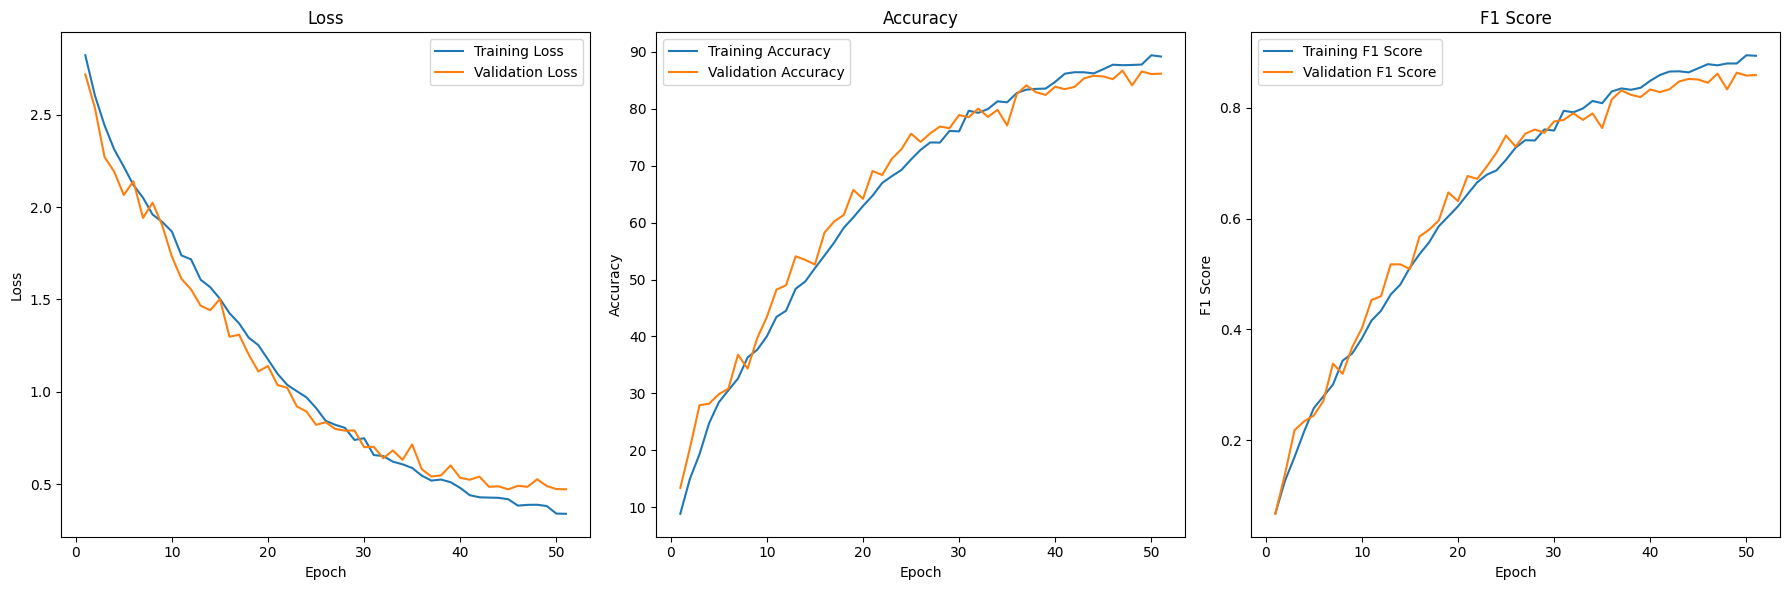

In [57]:
# Plotting the loss, accuracy, and F1 score
actual_epochs = len(train_loss)

epochs_range = range(1, actual_epochs + 1)

plt.figure(figsize=(18, 6))

# Plot training & validation loss values
plt.subplot(1, 3, 1)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')

# Plot training & validation accuracy values
plt.subplot(1, 3, 2)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')

# Plot training & validation F1 score values
plt.subplot(1, 3, 3)
plt.plot(epochs_range, train_f1_score, label='Training F1 Score')
plt.plot(epochs_range, val_f1_score, label='Validation F1 Score')
plt.title('F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

In [58]:
# Define the test dataset class
class TestJutePestDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform=None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
    
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = os.path.join(self.img_dir, self.dataframe.iloc[idx, 1])
        image = Image.open(img_name).convert('RGB')
        
        if self.transform:
            image = self.transform(image)
        
        return image

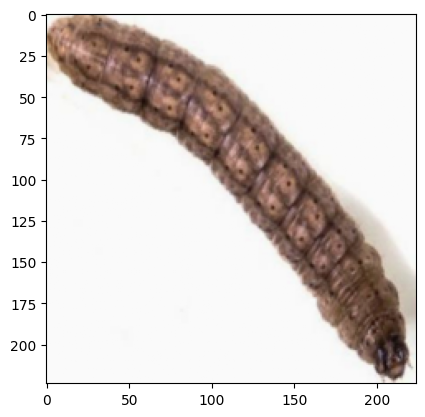

In [59]:
# Load and prepare test dataset
test_dir = '/kaggle/input/jutepest/test_images/'
test_csv = pd.read_csv('/kaggle/input/jutepest/test.csv')
test_dataset = TestJutePestDataset(test_csv, test_dir, transform)
plt.imshow(torch.permute(test_dataset[0], (1, 2, 0)))
plt.show()

In [60]:
# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [61]:
# Function for making predictions
def predict(model, test_loader):
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    
    return predictions


In [62]:
# Make predictions on test dataset
predictions = predict(model, test_loader)
predicted_labels = label_encoder.inverse_transform(predictions)

In [63]:
# Prepare submission file
test = pd.read_csv('/kaggle/input/jutepest/test.csv')
sub = pd.concat([test.id, pd.DataFrame(predicted_labels, columns=['class'])], axis=1)
sub.set_index('id', inplace=True)
sub.to_csv("submission_aug.csv")
sub

,class
id,
0,Cutworm
1,Jute Hairy
2,Black Hairy
3,Field Cricket
4,Black Hairy
...,...
1081,Termite
1082,Jute Hairy
1083,Jute Stem Girdler
